In [1]:
%env CUDA_PATH=/usr/local/cuda

env: CUDA_PATH=/usr/local/cuda


In [2]:
import os
import numpy as np
import opendatasets as od
import matplotlib.pyplot as plt
import json
from sklearn.metrics import confusion_matrix
from ml_genn import Network, Population, Connection
from ml_genn.callbacks import SpikeRecorder, VarRecorder
from ml_genn.compilers import InferenceCompiler
from ml_genn.connectivity import Dense
from ml_genn.neurons import LeakyIntegrate, LeakyIntegrateFire, SpikeInput
from ml_genn.synapses import Exponential

from ml_genn.utils.data import calc_latest_spike_time
from ml_genn.compilers.event_prop_compiler import default_params

from ml_genn.utils.data import (calc_latest_spike_time, calc_max_spikes,
                                preprocess_tonic_spikes)

from rawHD_dataset_loader_padded_spikes import rawHD_Loader

In [3]:
# sample ID used for visual
sample_id = 0

In [4]:
# loading parameter values from last successful run
param_dir = "output/rawHD_chapter_write_up_cross_validation/params.json"
#param_dir = "rawHD_params.json"

with open(param_dir, "r") as f:
        params = json.load(f)

params["num_samples"] = None
params["BATCH_SIZE"] = 64
params["recurrent"] = True
params["weights_dir"] = "/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/output/rawHD_chapter_write_up_cross_validation/"

In [5]:
params["DT_MS"] = 1.0
params["TAU_MEM"] = 20.0
params["TAU_SYN"] = 5.0
params["num_samples"] = None
params["sample_id"] = 0     #sample used for graph generation (starting at 0, < num_samples)
params["return_single_sample"] = None

#params["weights_dir"] = "rawHD_pretrained_weights_recurrent"
params["bit"] = 8
params["timesteps"] = 2000

params["output_dir"] = "rawHD_genn_inference"

params["neuron_dislay_id"] = 300

# toggle to record spikes, useful for debugging, but memory intensive
params["record_network_ih_activity"] =  True

In [6]:
x_train, y_train, z_train, x_test, y_test, z_test, x_validation, y_validation, z_validation = rawHD_Loader(dir = os.getcwd() + params["dataset_directory"],
                                                                                                           num_samples=params["num_samples"],
                                                                                                           shuffle = True,
                                                                                                           shuffle_seed = 0,
                                                                                                           process_padded_spikes = False)


In [7]:
# Kaggle dataset directory
dataset = 'https://www.kaggle.com/datasets/thomasshoesmith/spiking-google-speech-commands/data'

# Using opendatasets to download SGSC dataset
od.download(dataset)

#x_test = np.load("spiking-google-speech-commands/testing_x_spikes.npy", allow_pickle=True)
#y_test = np.load("spiking-google-speech-commands/testing_y_spikes.npy", allow_pickle=True)

# Preprocess
x_test_spikes = []
for i in range(len(x_test)):
    events = x_test[i]
    x_test_spikes.append(preprocess_tonic_spikes(events, 
                                                  x_test[0].dtype.names,
                                                  (params["NUM_INPUT"], 1, 1),
                                                  time_scale = 1))

# Determine max spikes and latest spike time
max_spikes = calc_max_spikes(x_test_spikes)
latest_spike_time = calc_latest_spike_time(x_test_spikes)
print(f"Max spikes {max_spikes}, latest spike time {latest_spike_time}")

Skipping, found downloaded files in "./spiking-google-speech-commands" (use force=True to force download)
Max spikes 2190, latest spike time 1599


In [8]:
# change directory for output code of (ML_)GeNN
try:
    os.makedirs("output/" + params["output_dir"] + "_inference_run")
except:
    pass

os.chdir("output/" + params["output_dir"] + "_inference_run")

In [11]:
accuracy_list = []
predict_list = []

for speaker in np.unique(z_train):
    print(f" ! Running Inference for Serialiser {speaker} !")
    
    # loading pretrained weights
    w_i2h = np.load(params["weights_dir"] + f"serialiser_{speaker}" + f"/{params['NUM_EPOCH'] - 1}-Conn_Pop0_Pop1-g.npy", allow_pickle = True)
    w_i2h = w_i2h.reshape((params["NUM_INPUT"], 
                        params["NUM_HIDDEN"]))

    if params["recurrent"]:
        w_h2h = np.load(params["weights_dir"] + f"serialiser_{speaker}" + f"/{params['NUM_EPOCH'] - 1}-Conn_Pop1_Pop1-g.npy", allow_pickle = True)
        w_h2h = w_h2h.reshape((params["NUM_HIDDEN"],
                            params["NUM_HIDDEN"]))

    w_h2o = np.load(params["weights_dir"] + f"serialiser_{speaker}" + f"/{params['NUM_EPOCH'] - 1}-Conn_Pop1_Pop2-g.npy", allow_pickle = True)
    w_h2o = w_h2o.reshape((params["NUM_HIDDEN"], 
                        params["NUM_OUTPUT"]))
    
    network = Network(default_params)

    with network:
        # Populations
        input = Population(SpikeInput(max_spikes = params["BATCH_SIZE"] * max_spikes),
                        params["NUM_INPUT"],
                        record_spikes=True)
        
        hidden = Population(LeakyIntegrateFire(v_thresh=1.0, 
                                        tau_mem=20.0),
                    params.get("NUM_HIDDEN"), 
                    record_spikes=True)
        
        output = Population(LeakyIntegrate(tau_mem=20.0, 
                                    readout="avg_var_exp_weight"),
                    params.get("NUM_OUTPUT"), 
                    record_spikes=True)

        Connection(input, hidden, Dense(weight = w_i2h),
                    Exponential(5.0))
        
        if params.get("recurrent"):
            Connection(hidden, hidden, Dense(weight = w_h2h),
                    Exponential(5.0))
        
        Connection(hidden, output, Dense(w_h2o),
                    Exponential(5.0))

    compiler = InferenceCompiler(evaluate_timesteps = params.get("NUM_FRAMES") * params.get("INPUT_FRAME_TIMESTEP"),
                                reset_in_syn_between_batches=True,
                                #quantise_num_weight_bits=8,
                                #quantise_weight_percentile=99,
                                batch_size = params.get("BATCH_SIZE"))

    compiled_net = compiler.compile(network)


    with compiled_net:

        callbacks = ["batch_progress_bar",
                    SpikeRecorder(input, 
                                key = "input_spikes",
                                example_filter = sample_id),
                    SpikeRecorder(hidden,
                                key = "hidden_spikes",
                                example_filter = sample_id),
                    VarRecorder(hidden, 
                                var = "v",
                                key = "hidden_voltages",
                                example_filter = sample_id),
                    VarRecorder(output, 
                                var = "v",
                                key = "output_voltages",
                                example_filter = sample_id)]
        
        
        e_metrics, e_cb_data = compiled_net.evaluate({input: x_test_spikes}, {output: y_test}, callbacks = callbacks)
        
        metrics, cb_data = compiled_net.predict({input: x_test_spikes}, output, callbacks = callbacks)

        #compiled_net.save(("quant8",), serialiser)


        print(f"Accuracy = {100 * e_metrics[output].result}%")
        
        accuracy_list.append(100 * e_metrics[output].result)
        predict_list.append(metrics[output])

 ! Running Inference for Serialiser 0 !
make: Entering directory '/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'


/its/home/ts468/PhD/ve/genn_5_1_0/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


make: Leaving directory '/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'


100%|██████████| 36/36 [00:00<00:00, 61.60it/s]


Accuracy = 84.18727915194346%
 ! Running Inference for Serialiser 1 !
make: Entering directory '/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'
make: Leaving directory '/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'


100%|██████████| 36/36 [00:00<00:00, 61.62it/s]


Accuracy = 89.04593639575971%
 ! Running Inference for Serialiser 2 !
make: Entering directory '/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'
make: Leaving directory '/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'


100%|██████████| 36/36 [00:00<00:00, 61.68it/s]


Accuracy = 89.75265017667844%
 ! Running Inference for Serialiser 3 !
make: Entering directory '/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'
make: Leaving directory '/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'


100%|██████████| 36/36 [00:00<00:00, 62.04it/s]


Accuracy = 82.24381625441696%
 ! Running Inference for Serialiser 6 !
make: Entering directory '/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'
make: Leaving directory '/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'


100%|██████████| 36/36 [00:00<00:00, 61.78it/s]


Accuracy = 87.32332155477032%
 ! Running Inference for Serialiser 7 !
make: Entering directory '/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'
make: Leaving directory '/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'


100%|██████████| 36/36 [00:00<00:00, 61.64it/s]


Accuracy = 90.37102473498233%
 ! Running Inference for Serialiser 8 !
make: Entering directory '/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'
make: Leaving directory '/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'


100%|██████████| 36/36 [00:00<00:00, 61.71it/s]


Accuracy = 89.0017667844523%
 ! Running Inference for Serialiser 9 !
make: Entering directory '/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'
make: Leaving directory '/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'


100%|██████████| 36/36 [00:00<00:00, 61.66it/s]


Accuracy = 87.45583038869258%
 ! Running Inference for Serialiser 10 !
make: Entering directory '/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'
make: Leaving directory '/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'


100%|██████████| 36/36 [00:00<00:00, 61.71it/s]


Accuracy = 87.41166077738515%
 ! Running Inference for Serialiser 11 !
make: Entering directory '/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'
make: Leaving directory '/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'


100%|██████████| 36/36 [00:00<00:00, 61.11it/s]

Accuracy = 86.66077738515902%


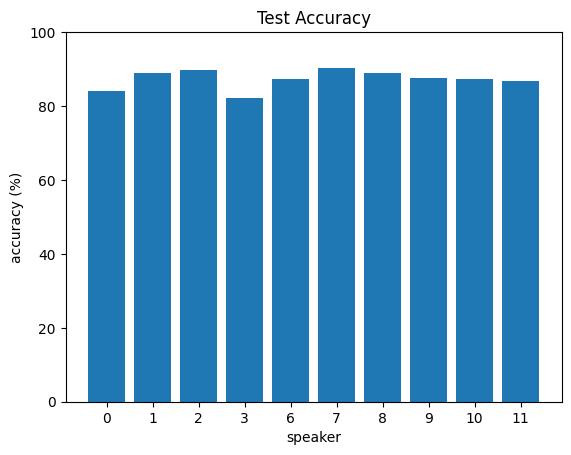

In [12]:
plt.bar(list(range(10)), accuracy_list)

plt.ylim(0, 100)
plt.ylabel("accuracy (%)")
plt.xlabel("speaker")
plt.xticks(list(range(10)), np.unique(z_train))
plt.title("Test Accuracy")
plt.show()

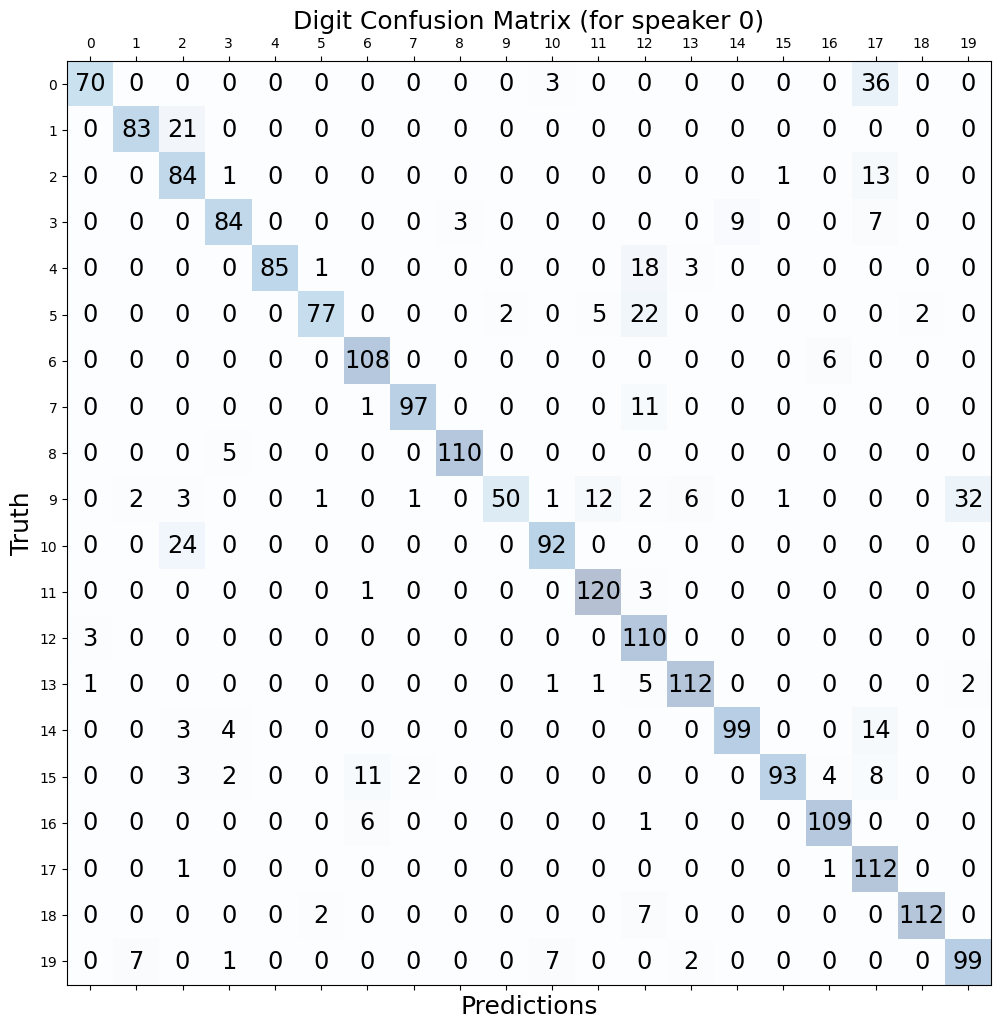

In [13]:
speaker_index = 0
cm = confusion_matrix(y_test, np.argmax(predict_list[speaker_index], 1))
fig, ax = plt.subplots(figsize=(12, 12))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Truth', fontsize=18)
plt.title(f'Digit Confusion Matrix (for speaker {speaker_index})', fontsize=18)
plt.xticks(list(range(20)))
plt.yticks(list(range(20)))
plt.show()

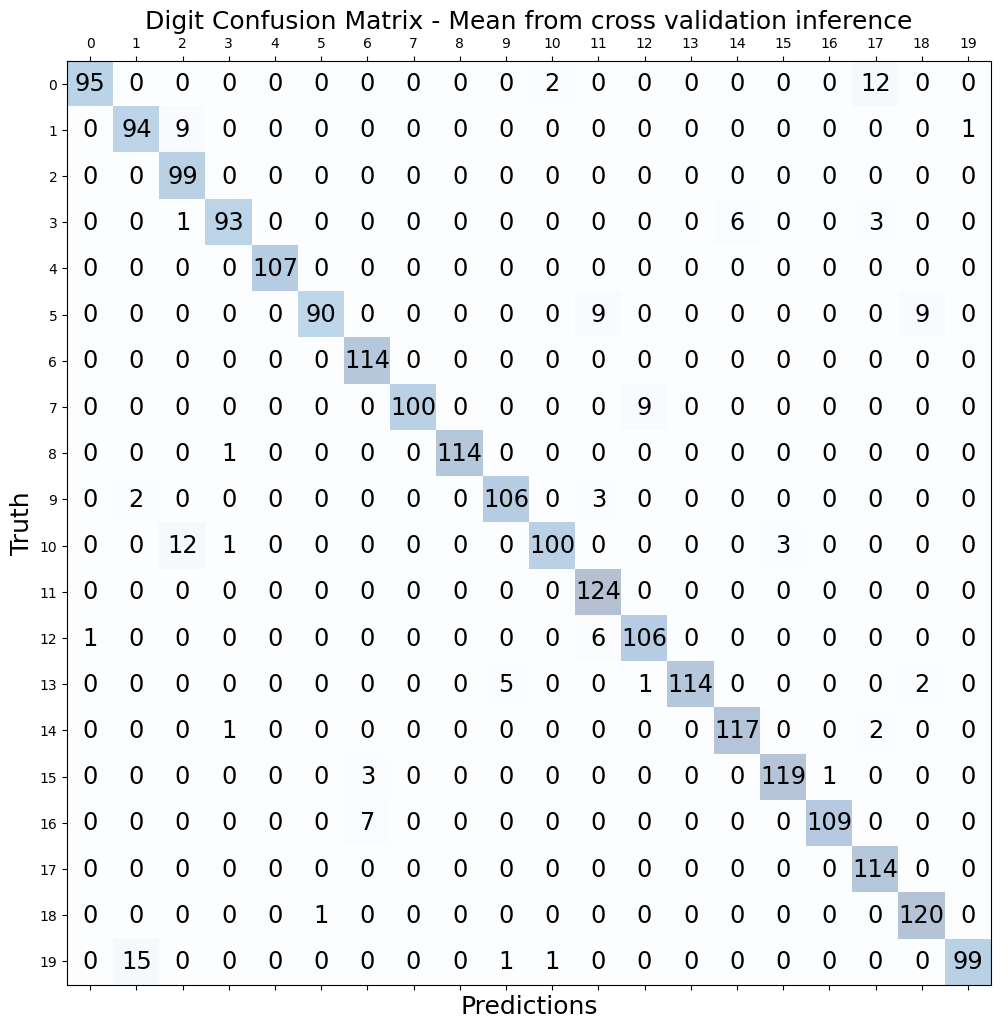

In [23]:
cm = confusion_matrix(y_test, np.argmax((np.sum(predict_list, 0)), 1))
fig, ax = plt.subplots(figsize=(12, 12))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Truth', fontsize=18)
plt.title('Digit Confusion Matrix - Mean from cross validation inference', fontsize=18)
plt.xticks(list(range(20)))
plt.yticks(list(range(20)))
plt.show()